# Intent Classification using Bert 

For this project, I will be building a Intent classifier in tensorflow. Lets start with importing the dependencies.

In [1]:
import os
import math
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='colorblind', font_scale=1.2)
sns.set_palette(sns.color_palette("rocket"))
rcParams['figure.figsize'] = 10, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Dataset

I will be using Benchmarking dataset from kaggle. There are two files, one for training and other for testing. The data in json format. I downloaded and converted them into csv for this work. 
There are seven intents in this dataset. They are as follows:

1. AddToPlaylist.json
2. PlayMusic.json
3. SearchScreeningEvent.json
4. BookRestaurant.json
5. RateBook.json
6. GetWeather.json
7. SearchCreativeWork.json

I will start by reading these files.

In [2]:
train = pd.read_csv('intent_train.csv', index_col=0)
test = pd.read_csv('intent_test.csv', index_col=0)

In [3]:
train.head()

,query,intent,category
10609,Where can I find The Brave Little Toaster To T...,SearchCreativeWork,5
1310,I am rating this essay two points,RateBook,0
624,Rate this album 4 points,RateBook,0
12828,I want to hear the Fear The Boom And Bust song...,PlayMusic,6
6247,Please book me a reservation this year for a r...,BookRestaurant,3


In [5]:
train.shape
test.shape

(700, 3)

There are Three columns in this dataset. Query is the text that I will be classifying. Category is just the intent, labeled as numeric. there are ~14k records in train and 700 in test.

# Download the model

I will download the bert model using google apis. I will be using Uncased and base version of this model. Unzip the model, make a folder and move our model in that folder.


In [10]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip
os.makedirs("model", exist_ok=True)
!mv uncased_L-12_H-768_A-12/ model
bert_model_name="uncased_L-12_H-768_A-12"
bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

--2021-05-20 17:50:07--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.80, 142.250.217.112, 142.251.33.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   220MB/s    in 1.8s    

2021-05-20 17:50:09 (220 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [21]:
class DataPreprocess(object):
    
    def __init__(self):
        
        self.max_len = 128
        
    def create_token_ids(self, sentence, maxlen):
        tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))
        tokens = tokenizer.tokenize(sentence)
        tokens = tokens[:maxlen]
        tokens = ["[CLS]"] + tokens + ["[SEP]"]
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        ids = token_ids + [0] * (max_len-len(token_ids))

        return ids

    def create_tensor_array(self, sentences):
        input_ids = []

        for sentence in tqdm(sentences,position=0, leave=True):
            ids=create_single_input(sentence,max_len-2)
            input_ids.append(ids)

        tensor = np.asarray(input_ids, dtype=np.int32)

        return tensor


In [16]:
train_sentences = train["query"].tolist()
test_sentences = test["query"].tolist()

# Preprocessing the data

Since we cannot feed the strings/text data to the machine. we need to convert our text to a numerical representation. I will use the tokenizer that comes with 
the bert model to break down sentences into words. Add special tokens like CLS and SEP for begining and ending of the sentences, respectively. Then, convert 
tokens into ids. Method that i created create_token_ids will do all these steps for us.

In [18]:
def create_token_ids(sentence,maxlen):
    max_len = 128
    tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:maxlen]
    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    ids = token_ids + [0] * (max_len-len(token_ids))

    return ids

Next method create_tensor_array will convert these tokens into tensors that we can feed into out model.

In [23]:
def create_tensor_array(sentences):
    max_len = 128
    input_ids = []

    for sentence in tqdm(sentences,position=0, leave=True):
        ids=create_single_input(sentence,max_len-2)

        input_ids.append(ids)

    tensor = np.asarray(input_ids, dtype=np.int32)

    return tensor

Lets use these methods for our text in training and test dataset.

In [24]:
train_sentences = train["query"].tolist()
test_sentences = test["query"].tolist()

In [25]:
train_x = create_input_array(train_sentences)
test_x = create_input_array(test_sentences)

100%|██████████| 700/700 [01:00<00:00, 11.58it/s]


I will an array for labels i.e. y variables. Since it is already in numbers, not much to do here.

In [26]:
def prepare_data_y(labels):
    y = list()
    for item in labels:
        label = item
        y.append(label)
    y = np.array(y)
    return y

In [27]:
train_labels = train["category"].tolist()
test_labels = test["category"].tolist()

In [28]:
train_y = prepare_data_y(train_labels)
test_y = prepare_data_y(test_labels)

# Build the model

Since we have prepared our x and y variables for both train and test dataset. It is time to train our model.

In [5]:
def create_model(max_seq_len, bert_ckpt_file):
    classes = train.intent.unique().tolist()

    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = None
        bert = BertModelLayer.from_params(bert_params, name="bert")

    input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
    bert_output = bert(input_ids)

    print("bert shape", bert_output.shape)

    x = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
    x = keras.layers.Dropout(0.2)(x)
    out = keras.layers.Dense(units=len(classes), activation="softmax")(x)

    model = keras.Model(inputs=input_ids, outputs=out)
    model.build(input_shape=(None, max_seq_len))

    load_stock_weights(bert, bert_ckpt_file)

    return model

In [6]:
model = create_model(128, bert_ckpt_file)

bert shape (None, 128, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fb28c5f9898> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 5383      
Total params: 108,895,495
Trainable params: 108,895,495
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [ ]:
history = model.fit(
  x=train_x, 
  y=train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5
)

I have used keras to build our model. For optimizer, Adam is used with learning rate of 1e-5. Loss function will be Sparse categorical crossentropy. I am using batch size of 16 and splitting 
training data into 10% validation set. I am doing only 5 epochs as it takes very long time to train this model.

# Evaluation of model

Let us plot loss and accuracy curve to check how my model has performed. 

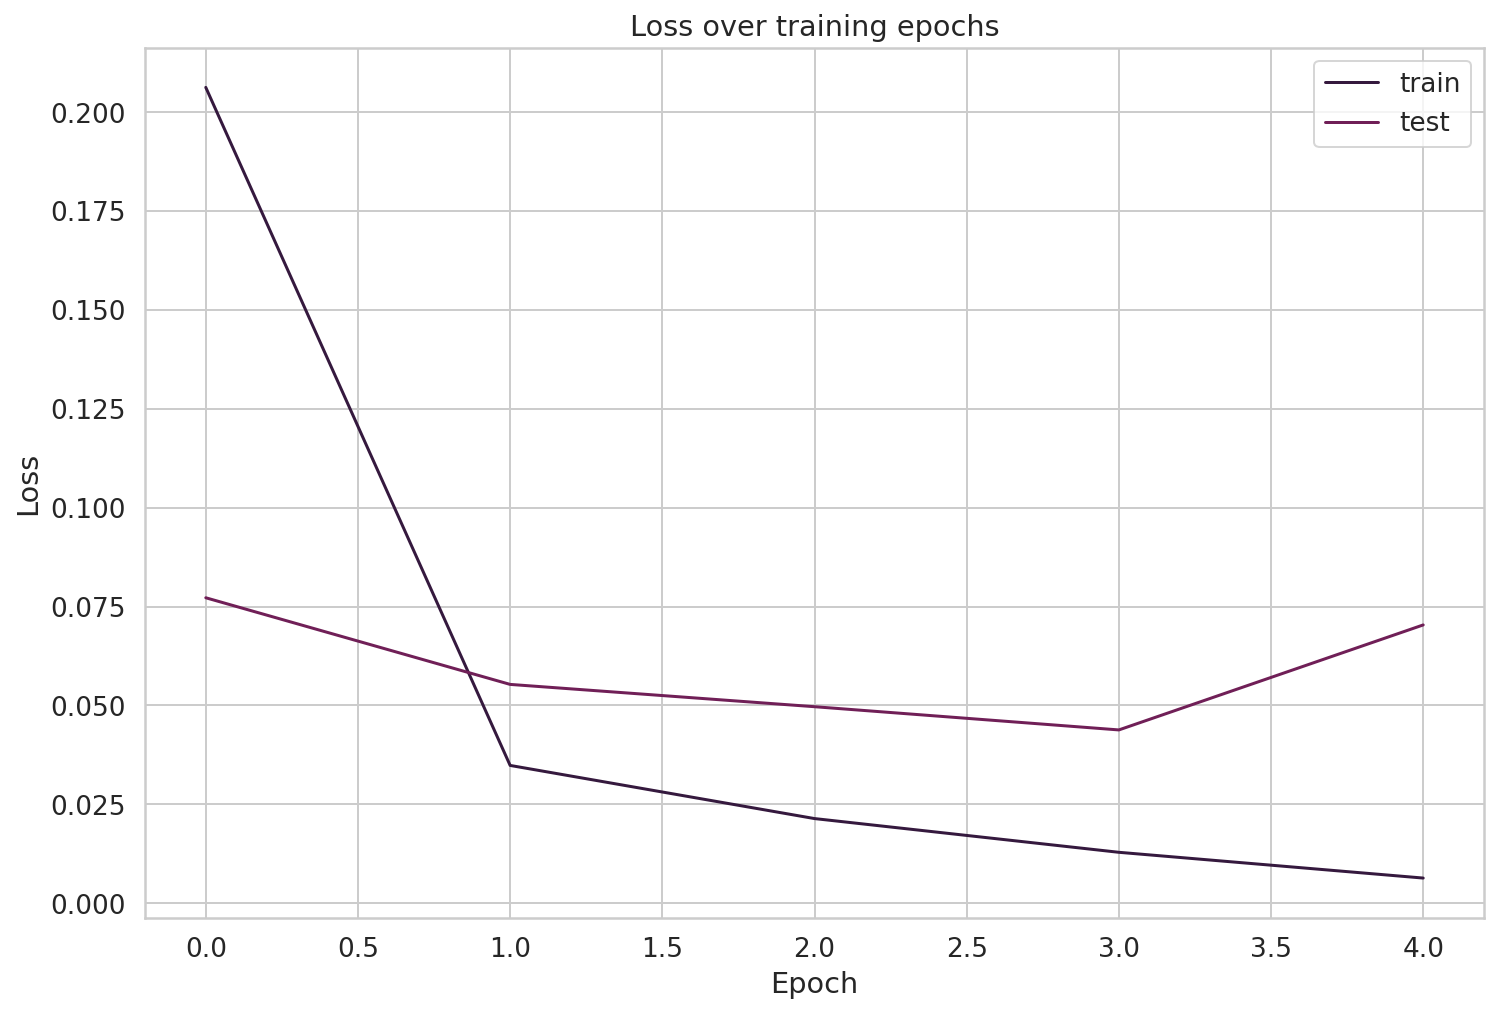

In [16]:
ax = plt.figure().gca()
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

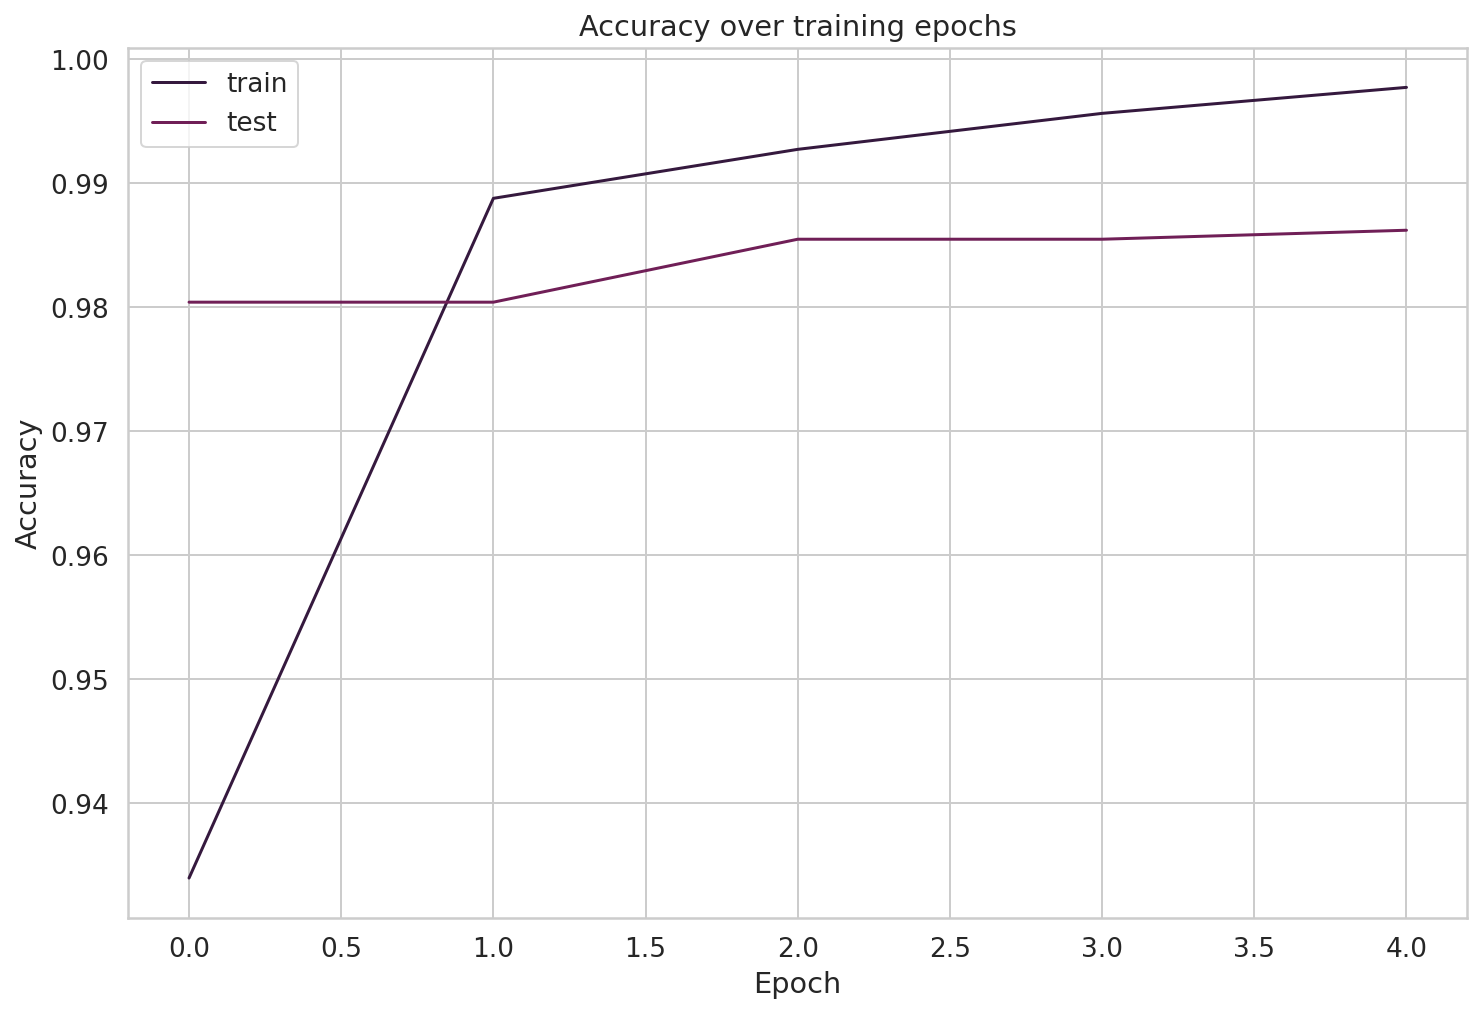

In [17]:
ax = plt.figure().gca()
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

Model accuracy:

In [20]:
_, train_acc = model.evaluate(train_x, train_y)
_, test_acc = model.evaluate(test_x, test_y)

print("train acc", train_acc)
print("test acc", test_acc)

22/22 [==============================] - 134s 6s/step - loss: 0.0822 - acc: 0.9843
train acc 0.998476505279541
test acc 0.9842857122421265


Model has accuracy of 99.8% on training data and 98.4% on test dataset. Pretty good for just 5 epochs.

In [22]:
y_pred = model.predict(test_x).argmax(axis=-1)

In [25]:
classes = train.intent.unique().tolist()

In [26]:
print(classification_report(test_y, y_pred, target_names=classes))

                      precision    recall  f1-score   support

  SearchCreativeWork       1.00      1.00      1.00       100
            RateBook       0.99      1.00      1.00       100
           PlayMusic       0.99      0.94      0.96       100
      BookRestaurant       0.99      1.00      1.00       100
SearchScreeningEvent       1.00      0.99      0.99       100
       AddToPlaylist       0.93      0.99      0.96       100
          GetWeather       1.00      0.97      0.98       100

            accuracy                           0.98       700
           macro avg       0.98      0.98      0.98       700
        weighted avg       0.98      0.98      0.98       700



In [28]:
cm = confusion_matrix(test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

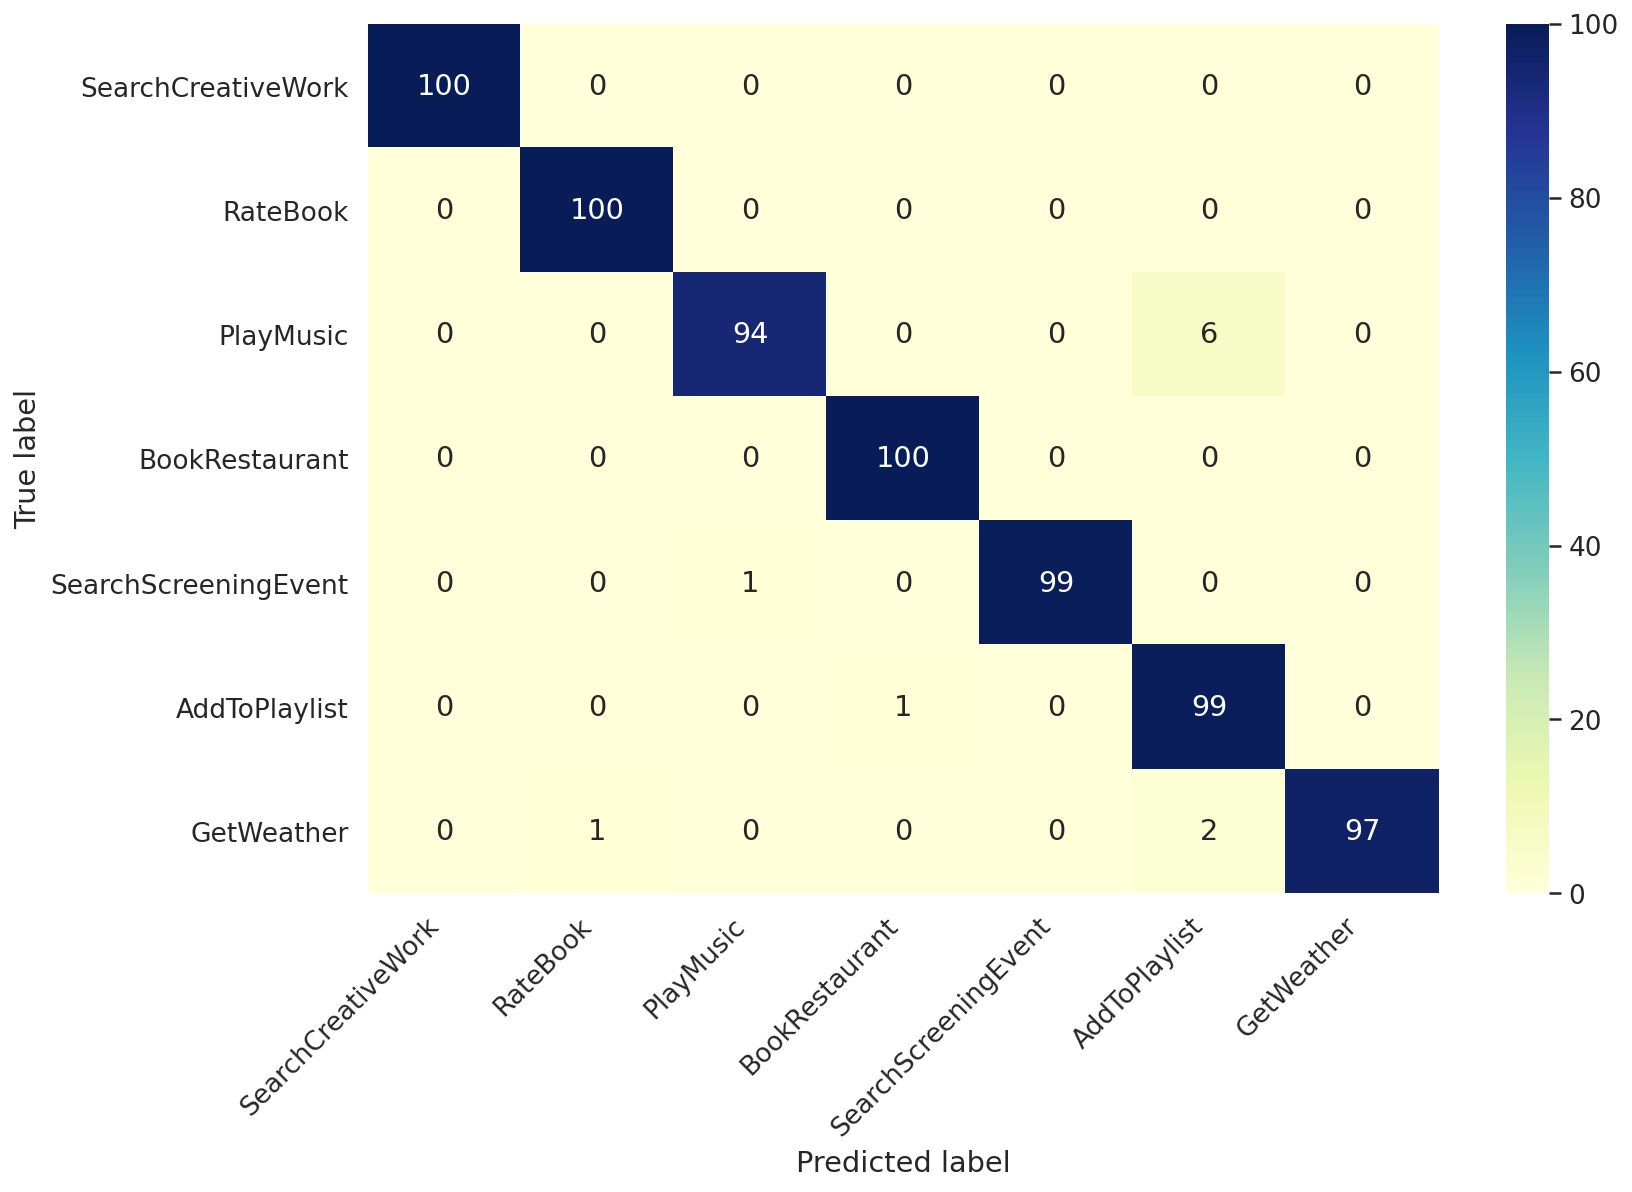

In [31]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

My model has performed quite well across all classes. A little less on PlayMusic but still pretty good.

# Making Predictions

I will create a class and method to test our model on new text data.

In [74]:
class Prediction():
    def __init__(self):
        self.model = model
           
    def predict(self,query):
        max_seq_len = 128
        tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))
        pred_tokens = map(tokenizer.tokenize, query)
        pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
        pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

        pred_token_ids = map(lambda tids: tids +[0]*(max_seq_len-len(tids)),pred_token_ids)
        pred_token_ids = np.array(list(pred_token_ids))

        predictions = model.predict(pred_token_ids).argmax(axis=-1)
        classes = train.category.unique().tolist()

        for text, label in zip(sentences, predictions):
            print("text:", text, "\nintent:", classes[label])
            print()
